<a href="https://colab.research.google.com/github/SibasisDash/bts_artifiical_intelligence/blob/master/bts_ai_2019_rnn_Sibasis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Names with a Character-Level RNN


Classifying Names with a Character-Level RNN
*********************************************

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch

Preparing the Data
==================

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2019-06-01 10:07:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.86.52, 13.32.86.49, 13.32.86.66, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.86.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.14MB/s    in 0.4s    

2019-06-01 10:07:33 (6.14 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: da

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
%matplotlib inline

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size()) #5 is the number of letters, 1 is the batch size , 57 letters = Capital letters + Small letters + " ,':;"

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
print(lineToTensor('Jones'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(torch.exp(output))

tensor([[0.0499, 0.0611, 0.0558, 0.0529, 0.0578, 0.0563, 0.0597, 0.0548, 0.0542,
         0.0568, 0.0530, 0.0546, 0.0562, 0.0538, 0.0512, 0.0562, 0.0617, 0.0541]],
       grad_fn=<ExpBackward>)


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(torch.exp(output))

tensor([[0.0499, 0.0611, 0.0558, 0.0529, 0.0578, 0.0563, 0.0597, 0.0548, 0.0542,
         0.0568, 0.0530, 0.0546, 0.0562, 0.0538, 0.0512, 0.0562, 0.0617, 0.0541]],
       grad_fn=<ExpBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 16)


We will also want a quick way to get a training example (a name and its
language):




In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Adamczak
category = Scottish / line = Stevenson
category = Irish / line = Mcguire
category = Vietnamese / line = Bach
category = Irish / line = Ivor
category = English / line = Mcauley
category = English / line = Emmott
category = Dutch / line = Breda
category = Dutch / line = Reijnders
category = German / line = Hermann


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [0]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8853 Tosell / Polish ✗ (Spanish)
10000 10% (0m 11s) 2.1592 Kavanagh / Italian ✗ (Irish)
15000 15% (0m 16s) 0.9641 Henderson / Scottish ✓
20000 20% (0m 21s) 1.9502 Oddy / English ✓
25000 25% (0m 26s) 1.9427 Loewe / German ✓
30000 30% (0m 31s) 0.7099 Snijders / Dutch ✓
35000 35% (0m 36s) 0.7209 Lefevre / French ✓
40000 40% (0m 41s) 0.1746 Armonni / Italian ✓
45000 45% (0m 46s) 2.0930 Morek / Polish ✗ (Czech)
50000 50% (0m 51s) 1.1033 Souza / Portuguese ✓
55000 55% (0m 56s) 1.7607 Cheung / Chinese ✓
60000 60% (1m 1s) 0.3782 Wan / Chinese ✓
65000 65% (1m 6s) 0.8506 Ortega / Spanish ✓
70000 70% (1m 11s) 0.4778 Lesauvage / French ✓
75000 75% (1m 16s) 2.5331 Bleskan / Russian ✗ (Czech)
80000 80% (1m 21s) 1.0719 Palmeiro / Portuguese ✓
85000 85% (1m 26s) 0.1482 Slaski / Polish ✓
90000 90% (1m 31s) 1.5639 Rios / Portuguese ✓
95000 95% (1m 36s) 0.3982 Mo / Korean ✓
100000 100% (1m 41s) 2.3220 Hay / Chinese ✗ (Scottish)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




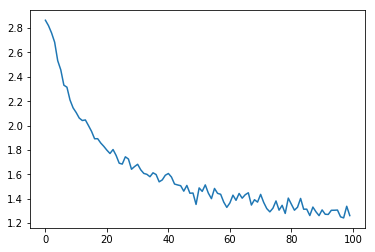

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




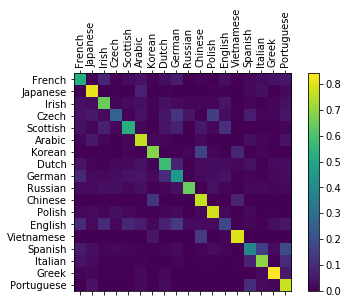

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = torch.exp(topv[0][i]).item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Daniel')
predict('Marc')
predict('Xavi')
predict('Satoshi')


> Daniel
(0.40) Portuguese
(0.33) French
(0.09) Irish

> Marc
(0.16) Dutch
(0.10) Arabic
(0.10) Portuguese

> Xavi
(0.17) Italian
(0.15) Chinese
(0.14) Polish

> Satoshi
(0.38) Japanese
(0.28) Italian
(0.13) Arabic


In [32]:
predict("Siba")
predict("Sibasis")
predict("Sibasis Dash")


> Siba
(0.38) Japanese
(0.30) Arabic
(0.09) Czech

> Sibasis
(0.39) Greek
(0.32) Arabic
(0.06) Spanish

> Sibasis Dash
(0.51) German
(0.21) Polish
(0.06) Czech


# Character prediction with an LSTM

Now, we will train a network to predict the following character of a sentence. Furthermore, by feeding the output of the network to itself, the network will be able to write new sentences. We will train our network using Alice's adventures in Wonderland.


Now, we will use the `nn.LSTMCell` module instead of implementing it ourselves.

We will train our network using Alice's adventures in Wonderland.



In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [19]:
!wget https://www.gutenberg.org/files/11/11.txt # Alice
# !wget http://www.gutenberg.org/files/1399/1399-0.txt # Ana Karenina

--2019-06-01 10:09:24--  https://www.gutenberg.org/files/11/11.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167546 (164K) [text/plain]
Saving to: ‘11.txt’

11.txt              100%[===================>] 163.62K  --.-KB/s    in 0.1s    

2019-06-01 10:09:25 (1.21 MB/s) - ‘11.txt’ saved [167546/167546]



In [0]:
# read and prepare the data
with open('./11.txt', 'r') as f: text = f.read() # Alice
# with open('./1399-0.txt', 'r') as f: text = f.read() # Ana Karenina
    
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
    
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
        )

def letterToIndex(letter):
    return all_letters.find(letter)

def indexToLetter(idx):
    return all_letters[idx]

text = unicodeToAscii(text)

# encode the text, using the character to integer function
encoded = np.array([letterToIndex(char) for char in text])

In [21]:
print(text)
print(encoded)

Project Gutenberg's Alice's Adventures in Wonderland, by Lewis CarrollThis eBook is for the use of anyone anywhere at no cost and withalmost no restrictions whatsoever.  You may copy it, give it away orreuse it under the terms of the Project Gutenberg License includedwith this eBook or online at www.gutenberg.orgTitle Alice's Adventures in WonderlandAuthor Lewis CarrollPosting Date June ,  EBook Release Date March, Last updated December , Language EnglishCharacter set encoding ASCII START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ALICE'S ADVENTURES IN WONDERLANDLewis CarrollTHE MILLENNIUM FULCRUM EDITION .CHAPTER I. Down the RabbitHoleAlice was beginning to get very tired of sitting by her sister on thebank, and of having nothing to do once or twice she had peeped into thebook her sister was reading, but it had no pictures or conversations init, 'and what is the use of a book,' thought Alice 'without pictures orconversations'So she was considering in her own mind

In [0]:
class CharLSTM(nn.ModuleList):
    def __init__(self, sequence_len, vocab_size, hidden_dim, batch_size):
        super(CharLSTM, self).__init__()
        
        # init the meta parameters
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.sequence_len = sequence_len
        self.vocab_size = vocab_size
        
        # first layer lstm cell
        self.lstm_1 = nn.LSTMCell(input_size=vocab_size, hidden_size=hidden_dim)
        
        # second layer lstm cell
        self.lstm_2 = nn.LSTMCell(input_size=hidden_dim, hidden_size=hidden_dim) 
        
        # dropout layer for the output of the second layer cell
        self.dropout = nn.Dropout(p=0.5)
        
        # fully connected layer to connect the output of the LSTM cell to the output
        self.fc = nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        
    def forward(self, x, hc):
        """
            x: input to the model
                *  x[t] - input of shape (batch, input_size) at time t
                
            hc: hidden and cell states
                *  tuple of hidden and cell state
        """ 
        
        # empty tensor for the output of the lstm
        output_seq = torch.empty((self.sequence_len, 
                                  self.batch_size, 
                                  self.vocab_size)).cuda()
        
        # pass the hidden and the cell state from one lstm cell to the next one
        # we also feed the output of the first layer lstm cell at time step t to the second layer cell
        # init the both layer cells with the zero hidden and zero cell states
        hc_1, hc_2 = hc, hc
        
        # for every step in the sequence
        for t in range(self.sequence_len):
            
            # get the hidden and cell states from the first layer cell
            hc_1 = self.lstm_1(x[t], hc_1)
            
            # unpack the hidden and the cell states from the first layer
            h_1, c_1 = hc_1
        
            # pass the hidden state from the first layer to the cell in the second layer
            hc_2 = self.lstm_2(h_1, hc_2)
            
            # unpack the hidden and cell states from the second layer cell
            h_2, c_2 = hc_2
        
            # form the output of the fc
            output_seq[t] = self.fc(h_2)
        
        # return the output sequence
        return output_seq.view((self.sequence_len * self.batch_size, -1))
          
    def init_hidden(self):
        
        # initialize the hidden state and the cell state to zeros
        return (torch.zeros(self.batch_size, self.hidden_dim), torch.zeros(self.batch_size, self.hidden_dim))

    def init_hidden_predict(self):
        
        # initialize the hidden state and the cell state to zeros
        # batch size is 1
        return (torch.zeros(1, self.hidden_dim),torch.zeros(1, self.hidden_dim))
    
    def predict(self, char, top_k=5, seq_len=128):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        
        # set the evaluation mode
        self.eval()
        
        # placeholder for the generated text
        seq = np.empty(seq_len+1)
        seq[0] = letterToIndex(char)
        
        # initialize the hidden and cell states
        h, c = self.init_hidden_predict()
        h, c = h.cuda(), c.cuda()
        hc = (h, c)
        
        # now we need to encode the character - (1, vocab_size)
        char = to_categorical(letterToIndex(char), num_classes=self.vocab_size)
        
        # add the batch dimension
        char = torch.from_numpy(char).unsqueeze(0).cuda()
        
        # now we need to pass the character to the first LSTM cell to obtain 
        # the predictions on the second character
        hc_1, hc_2 = hc, hc
        
        # for the sequence length
        for t in range(seq_len):
            
            # get the hidden and cell states from the first LSTM layer
            hc_1 = self.lstm_1(char, hc_1)
            h_1, _ = hc_1
            
            # get the hidden and cell states from the second LSTM layer
            hc_2 = self.lstm_2(h_1, hc_2)
            h_2, _ = hc_2            
            
            # pass the output of the cell through fully connected layer
            h_2 = self.fc(h_2)
            
            # apply the softmax to the output to get the probabilities of the characters
            h_2 = F.softmax(h_2, dim=1)
            
            # h_2 now holds the vector of predictions (1, vocab_size)
            # we want to sample 5 top characters
            p, top_char = h_2.topk(top_k)
            
            # get the top k characters by their probabilities
            top_char = top_char.squeeze().cpu().numpy()
            
            # sample a character using its probability
            p = p.detach().squeeze().cpu().numpy()
            char = np.random.choice(top_char, p = p/p.sum())
        
            # append the character to the output sequence
            seq[t+1] = char
            
            # prepare the character to be fed to the next LSTM cell
            char = to_categorical(char, num_classes=self.vocab_size)
            char = torch.from_numpy(char).unsqueeze(0).cuda()
            
        return seq

We need to write the batching algorithm that will feed the data to our network.

In [0]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

# batching function
def get_batches(arr, n_seqs_in_a_batch, n_characters):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs_in_a_batch * n_characters
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs_in_a_batch, -1))
    
    for n in range(0, arr.shape[1], n_characters):
        # The features
        x = arr[:, n:n+n_characters]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_characters]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

Declare the network, the optimizer and the loss that we will use during training.

In [0]:
# compile the network - sequence_len, vocab_size, hidden_dim, batch_size
net = CharLSTM(sequence_len=128, vocab_size=len(all_letters), hidden_dim=512, batch_size=100).cuda()

# define the loss and the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().cuda()

Do training and validation. The `samples` variable will save network predictions every 5 gradient steps.

In [25]:
# get the validation and the training data
val_idx = int(len(encoded) * (1 - 0.1))
data, val_data = encoded[:val_idx], encoded[val_idx:]

# empty list for the validation losses
train_losses = []
val_losses = []

# empty list for the samples
samples = []
samples.append(''.join([indexToLetter(int(int_)) for int_ in net.predict("A", seq_len=1024)]))

i = 0

for epoch in range(50):
    
    # reinit the hidden and cell steates
    hc = net.init_hidden()
    h, c = hc[0].cuda(), hc[1].cuda()
    hc = (h, c)
    net.train()
    for x, y in get_batches(data, 100, 128):
        
        # get the torch tensors from the one-hot of training data
        # also transpose the axis for the training set and the targets
        x_train = torch.from_numpy(to_categorical(x, num_classes=net.vocab_size).transpose([1, 0, 2]))
        targets = torch.from_numpy(y.T).type(torch.LongTensor)  # tensor of the target
        x_train, targets = x_train.cuda(), targets.cuda()
        
        # zero out the gradients
        optimizer.zero_grad()
        
        # get the output sequence from the input and the initial hidden and cell states
        output = net(x_train, hc)
    
        # calculate the loss
        # we need to calculate the loss across all batches, so we have to flat the targets tensor
        loss = criterion(output, targets.contiguous().view(-1))
        
        # calculate the gradients
        loss.backward()
        
        # update the parameters of the model
        optimizer.step()
    
        # feedback every 5 batches
        if i % 5 == 0: 
            
            # initialize the validation hidden state and cell state
            val_h, val_c = net.init_hidden()
            val_h, val_c = val_h.cuda(), val_c.cuda()
            net.eval()
            tmp_losses = []
            for val_x, val_y in get_batches(val_data, 100, 128):
                
                # prepare the validation inputs and targets
                val_x = torch.from_numpy(to_categorical(val_x).transpose([1, 0, 2]))
                val_y = torch.from_numpy(val_y.T).type(torch.LongTensor).contiguous().view(-1)
                val_x, val_y = val_x.cuda(), val_y.cuda()
            
                # get the validation output
                val_output = net(val_x, (val_h, val_c))
                
                # get the validation loss
                val_loss = criterion(val_output, val_y)
                
                # append the validation loss
                tmp_losses.append(val_loss.item())
                
                # sample 256 chars
                samples.append(''.join([indexToLetter(int(int_)) for int_ in net.predict("A", seq_len=1024)]))
            val_loss = np.mean(tmp_losses)
            val_losses.append(val_loss)
            train_losses.append(loss.item())
            print("Epoch: {}, Total steps: {}, Train Loss: {:.6f}, Validation Loss: {:.6f}".format(epoch, i, loss.item(), val_loss.item()))
                
        i += 1

Epoch: 0, Total steps: 0, Train Loss: 4.035418, Validation Loss: 4.004308
Epoch: 0, Total steps: 5, Train Loss: 3.587949, Validation Loss: 3.524939
Epoch: 0, Total steps: 10, Train Loss: 3.177972, Validation Loss: 3.348414
Epoch: 1, Total steps: 15, Train Loss: 3.139818, Validation Loss: 3.283292
Epoch: 1, Total steps: 20, Train Loss: 3.097121, Validation Loss: 3.290838
Epoch: 2, Total steps: 25, Train Loss: 3.105004, Validation Loss: 3.295204
Epoch: 2, Total steps: 30, Train Loss: 3.088285, Validation Loss: 3.280482
Epoch: 3, Total steps: 35, Train Loss: 3.064233, Validation Loss: 3.266756
Epoch: 3, Total steps: 40, Train Loss: 3.063167, Validation Loss: 3.259575
Epoch: 4, Total steps: 45, Train Loss: 3.101564, Validation Loss: 3.263737
Epoch: 4, Total steps: 50, Train Loss: 3.059070, Validation Loss: 3.266162
Epoch: 5, Total steps: 55, Train Loss: 3.082891, Validation Loss: 3.264193
Epoch: 5, Total steps: 60, Train Loss: 3.054140, Validation Loss: 3.260613
Epoch: 5, Total steps: 65, 

Plot the losses.

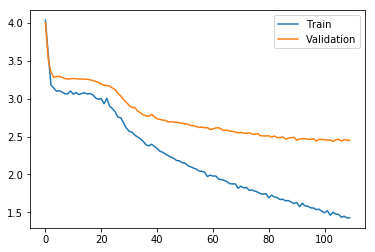

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train", "Validation"])

See some generated text samples.

In [27]:
print(samples[0])
print(samples[5])
print(samples[-1])

A IzQz E Ez QuE z Ez EzzzzQ QQIIQQIz uQ zEQIzuuEQ QQ  u  uzuuu zzuzu zEzEzEzQzz  zE zQQ zQzQzz u QQQQuuQQQuIEu  QI   E z QIzEQ uuu zz zQuz uQzz zQ Q  Qu QQzQz Ez zzQ u uQQ uQ  Q u EuzEuQ IIEuEEuQQuIuEQ QzI   z z QzEEz  u Q zzu Ezu  QuuzuEzzEu EzEz QQ QzQIIzu Qz EEz uz zQE Q IIzQQuuEuzQEzEzQzuzzQEzz uQ QzQuQQ Q IuuzEQuQ Iu uu zuzuu QQzI zzEQz QzuE uuuEQ Q zQQII z z QuzE EEQI zuEQ uQQI IuuzEQQIIQIz QzzzQQ uEzQ uEzz Qzu  QQQI uuQEEE  IIQQu uu  QIzzzu  EuQIuuu zuQEQIzzE EzEQQ IuzEQzuzuEu EE uz QIIu  QzuuQz Eu  uzEu QzQuuEQuuQIQu EQ  IQzQzEu EEuQQQ  zQzQuQ IQQzQ Iz EuQIQIu Quz uQuQQuzEu Eu  zzuz zuuEu zQ uu  EzQzzEu z Ezu E zuzzuQzu uu EQIuzuuz zEQIuuzuEE u uzQzz zuE  Q zQuE  zQz  uQIuQIzz uz QQuu u QuEQQI zQIEu QuuuzuE Qzz  EQu uEu  zzuEzz EEQQQu uQ uuEzzE  uQ Q  zQzEQQ zuu  uQu Quz zQQQ QzQzzu EuQzuQuQzzzuEzu uEQI QQQQIQIIzE  u  u zuuuE   E  Iz E uzQ  EE u zE QzuzQuuzQQzEuzQQIuzz uzz  Q I  Q zEQQzI uuu z  u Q  Qu z EQ   uEzEuQuzEEuzz QIzzzQQ zE EEEz  Q uEuzuuzuuE uzzuEzzzzzu zEzzQ uE uEQu

**Exercise: ** did the network overfit? Try adding dropout and doing early stopping to improve its performance. You can also try to train the model with Ana Karenina or other books in txt format.